In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
import numpy as np

from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

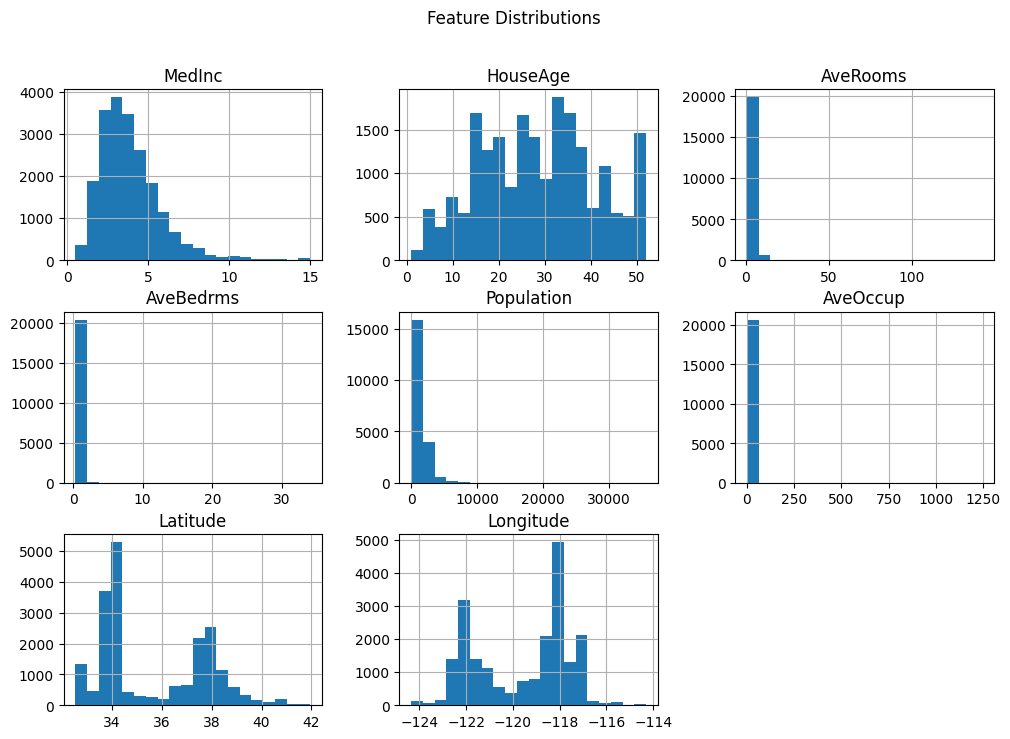

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

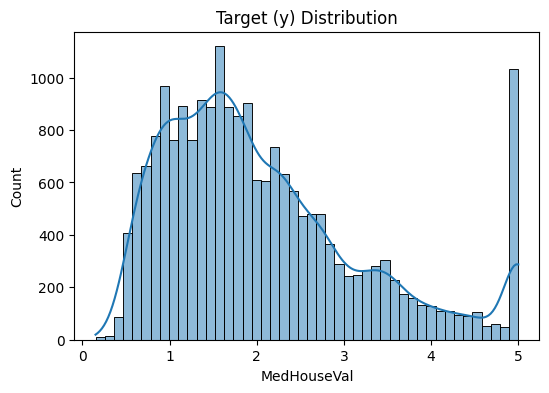

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

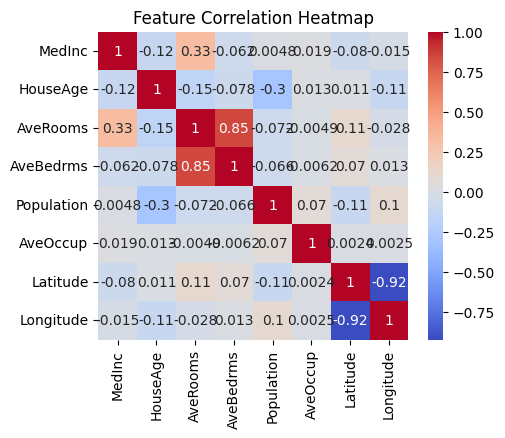

In [7]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [9]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=500, nskip=200, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.605152                 1.675718             1.300611   
1                  1.692071                 1.699732             1.343705   
2                  1.736173                 1.790325             1.567459   
3                  1.689882                 1.821722             1.708694   
4                  1.718366                 1.675447             1.360037   
mean               1.688329                 1.732589             1.456101   
std                0.050314                 0.068661             0.174816   

      DefaultBART_Rhat_RMSE  
0                  1.809039  
1                  1.800129  
2                  2.037297  
3                  1.917951  
4                  1.561434  
mean               1.825170  
std                0.176104  


In [10]:
rhat_df.to_csv("results/real3_CalHousing_rhat.csv", index=False)

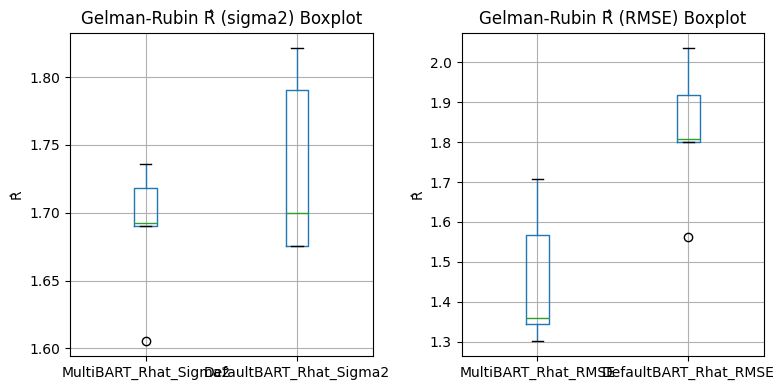

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

c:\Learning\Phd\BART\bartpy\bart_env\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


test_mse:
      bart_mtmh      bart       btz       sto        rf       xgb
0      0.223962  0.265041  0.320865  0.382689  0.272077  0.218599
1      0.237103  0.251451  0.335377  0.360276  0.261053  0.217833
2      0.234361  0.268103  0.340964  0.366874  0.262780  0.226877
3      0.221545  0.243460  0.317956  0.368247  0.244403  0.213037
4      0.231143  0.261127  0.327249  0.383958  0.265763  0.223567
5      0.222604  0.252846  0.329163  0.314131  0.256011  0.223564
6      0.227095  0.264714  0.334229  0.361174  0.266254  0.228732
7      0.232595  0.267991  0.331354  0.374838  0.272183  0.226946
8      0.233494  0.265903  0.316538  0.357483  0.258861  0.219225
9      0.228135  0.262472  0.340418  0.371033  0.250178  0.214931
mean   0.229204  0.260311  0.329411  0.364070  0.260956  0.221331
std    0.005353  0.008275  0.008768  0.019698  0.008964  0.005385



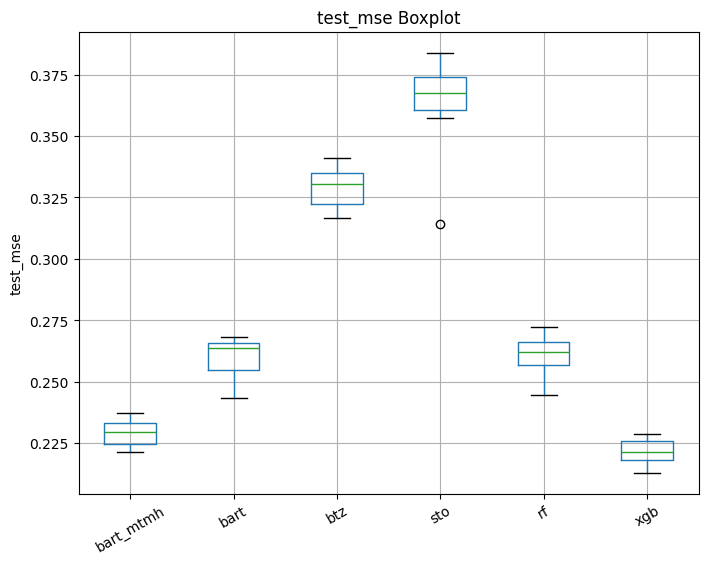

train_mse:
      bart_mtmh      bart       btz       sto        rf       xgb
0      0.176148  0.231167  0.309923  0.364836  0.036417  0.070528
1      0.177685  0.220919  0.314415  0.342571  0.036316  0.071458
2      0.175461  0.223738  0.309738  0.332146  0.035701  0.067329
3      0.181353  0.229076  0.311987  0.379100  0.036103  0.072052
4      0.173240  0.228654  0.310253  0.367600  0.034991  0.072937
5      0.170396  0.224959  0.318649  0.299326  0.036166  0.067958
6      0.177188  0.229231  0.309601  0.331654  0.035877  0.070881
7      0.174479  0.229343  0.303311  0.360475  0.036120  0.072070
8      0.176032  0.233281  0.298633  0.343981  0.035792  0.069747
9      0.174657  0.225767  0.312101  0.341717  0.035288  0.072473
mean   0.175664  0.227614  0.309861  0.346341  0.035877  0.070743
std    0.002891  0.003710  0.005545  0.022939  0.000453  0.001893



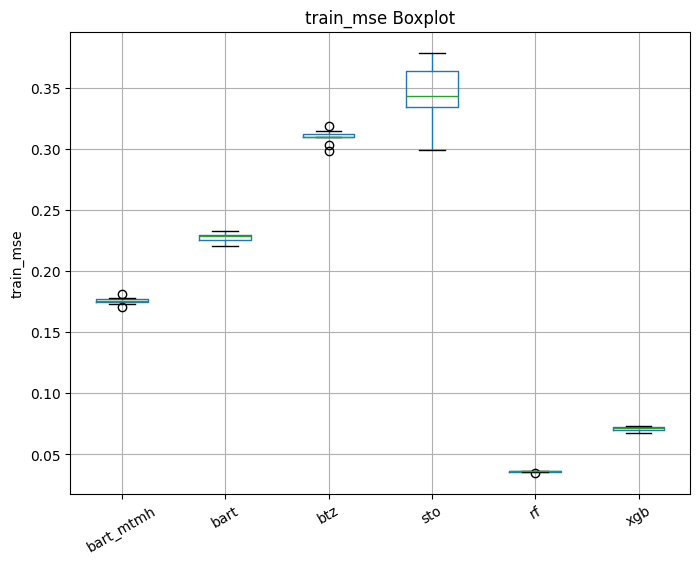

pi_length:
      bart_mtmh      bart       btz       sto
0      1.644648  1.852887  2.309107  1.508018
1      1.644838  1.818129  2.296956  1.537444
2      1.651468  1.830155  2.320480  1.484997
3      1.671061  1.844612  2.357827  1.550262
4      1.640807  1.848783  2.319387  1.577367
5      1.633546  1.822102  2.360883  1.350976
6      1.645889  1.839908  2.319293  1.506070
7      1.643054  1.850994  2.334369  1.513641
8      1.647034  1.860044  2.283676  1.485123
9      1.634344  1.842548  2.313801  1.514652
mean   1.645669  1.841016  2.321578  1.502855
std    0.010476  0.013658  0.024250  0.060543



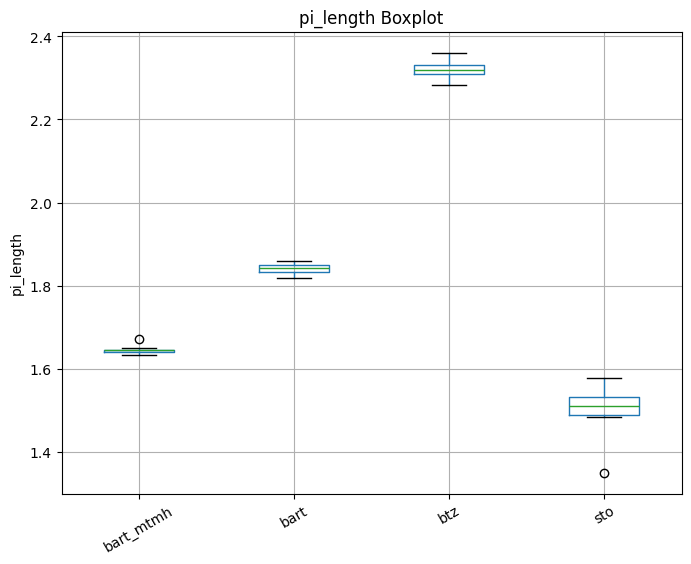

coverage:
      bart_mtmh      bart       btz       sto
0      0.920543  0.926357  0.947674  0.705620
1      0.918605  0.931589  0.939729  0.719574
2      0.924225  0.926550  0.941473  0.718411
3      0.928682  0.934109  0.949806  0.746124
4      0.927519  0.935078  0.949806  0.729651
5      0.921124  0.928876  0.943023  0.715310
6      0.926163  0.929845  0.944574  0.729845
7      0.922674  0.926744  0.946512  0.723450
8      0.927326  0.929651  0.943605  0.746318
9      0.924806  0.930233  0.937403  0.711047
mean   0.924167  0.929903  0.944360  0.724535
std    0.003359  0.003025  0.004157  0.013675



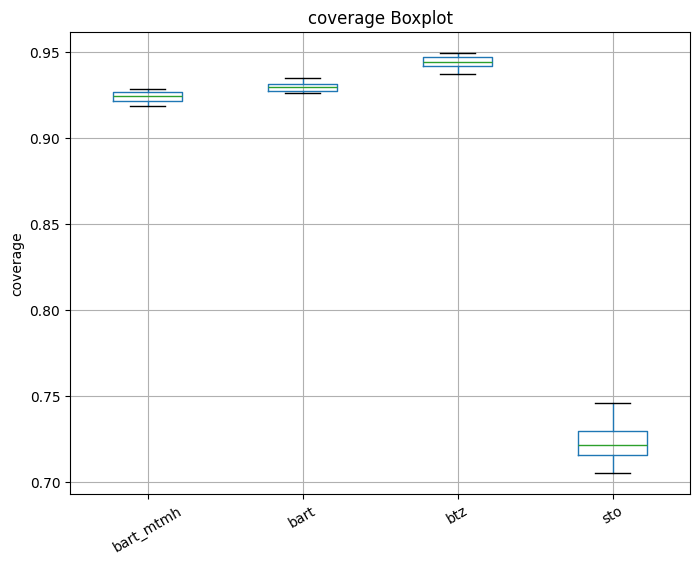

train_time:
      bart_mtmh      bart       btz        sto         rf       xgb
0     46.147668  5.632187  7.416574  16.764513  12.551098  0.238045
1     47.647587  5.840476  8.175285  15.744277  12.636145  0.215453
2     47.663910  5.833913  8.333107  15.667751  12.431287  0.218056
3     47.495000  5.877870  8.216146  15.751705  12.366407  0.220839
4     47.223555  5.793112  7.811596  16.215220  12.616947  0.213858
5     48.371468  6.145037  7.300905  16.875438  12.777323  0.203666
6     47.627430  6.176410  7.639901  16.569664  12.836502  0.175073
7     48.369252  6.184317  8.035678  16.039883  12.909868  0.198183
8     48.204073  6.246991  8.334515  15.873207  12.877656  0.198890
9     48.171034  6.524884  8.475520  16.052112  13.068927  0.195461
mean  47.692098  6.025520  7.973923  16.155377  12.707216  0.207752
std    0.671828  0.271244  0.410309   0.439457   0.224213  0.017312



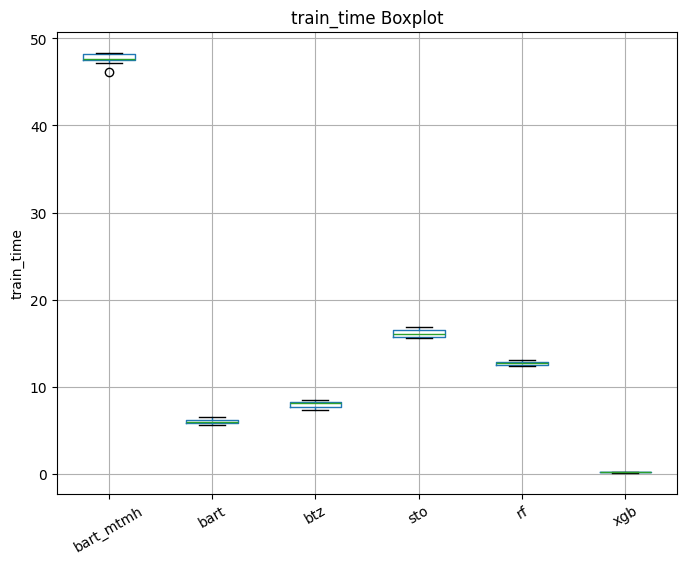

In [12]:
import matplotlib.pyplot as plt

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=100, n_post=100, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [13]:
for k, v in mse_results.items():
    csv_name = f"results/real3_CalHousing_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [9]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real3_CalHousing_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[100],
    n_runs=5, n_chains=4,
    ndpost=500, nskip=200, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real3_CalHousing_tries.csv", index=False)

In [10]:
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE  Test_MSE  Coverage   Train_Time
0            1     1.802836   2.002516  0.239122  0.938411    35.520867
1            5     1.735094   1.689518  0.219811  0.934225    96.638183
2           10     1.688329   1.456101  0.215413  0.933682   167.438289
3           50     1.710668   1.414388  0.214728  0.929070   745.021675
4          100     1.803933   1.533156  0.213976  0.926899  1551.891165
